# Unet - Constructed from the main CNN encoder and Decoder

This notebook shows how to use the CNN encoder and decoder network, glueing them 
together such that an Unet architecture emerges

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../Shared_Resources/Shared_Scripts')
sys.path.append('./utils')


from utils_unet_from_encoder_decoder import UNet
from utils_dataset_handling import *
from utils_segmentation_training import *
from utils_save_and_load_model import *

## Download the data set

In [3]:
data_save_dir = '../../Shared_Resources/Shared_Data/'

In [4]:
# Oxford IIIT Pets Segmentation dataset loaded via torchvision.
pets_path_train = os.path.join(data_save_dir, 'OxfordPets', 'train')
pets_path_test = os.path.join(data_save_dir, 'OxfordPets', 'test')

In [5]:
target_types = 'segmentation'
pets_train_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_train, split="trainval", 
                                                target_types=target_types, download=True)
pets_test_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_test, split="test", 
                                                target_types=target_types, download=True)

## Preprocess the data

In [6]:
image_size = 48

In [7]:
common_transform = T.Compose([
        ToDevice(get_device()),
        T.Resize((image_size,image_size), interpolation=T.InterpolationMode.NEAREST),
        # Random Horizontal Flip as data augmentation.
        T.RandomHorizontalFlip(p=0.5),
    ])

post_transform = T.Compose([
        # Color Jitter as data augmentation.
        T.ColorJitter(contrast=0.3),
    ])

In [8]:
transform_dict = args_to_dict(
    pre_transform=T.ToTensor(),
    pre_target_transform=T.ToTensor(),
    common_transform=common_transform,
    post_transform=post_transform,
    post_target_transform=T.Compose([
        T.Lambda(tensor_trimap),
    ]),
)

In [9]:
# Create the train and test instances of the data loader for the
# Oxford IIIT Pets dataset with random augmentations applied.
# The images are resized to 128x128 squares, so the aspect ratio
# will be chaged. We use the nearest neighbour resizing algorithm
# to avoid disturbing the pixel values in the provided segmentation
# mask.
pets_train = OxfordIIITPetsAugmented(
    root=pets_path_train,
    split="trainval",
    target_types="segmentation",
    download=False,
    **transform_dict,
)
pets_test = OxfordIIITPetsAugmented(
    root=pets_path_test,
    split="test",
    target_types="segmentation",
    download=False,
    **transform_dict,
)

pets_train_loader = torch.utils.data.DataLoader(
    pets_train,
    batch_size=12,
    shuffle=True,
)

pets_test_loader = torch.utils.data.DataLoader(
    pets_test,
    batch_size=6,
    shuffle=True,
)

In [10]:
(train_pets_inputs, train_pets_targets) = next(iter(pets_train_loader))
(test_pets_inputs, test_pets_targets) = next(iter(pets_test_loader))
train_pets_inputs.shape, train_pets_targets.shape

(torch.Size([12, 3, 48, 48]), torch.Size([12, 1, 48, 48]))

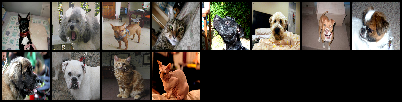

In [11]:
# Let's inspect some of the images.
pets_input_grid = torchvision.utils.make_grid(train_pets_inputs, nrow=8)
t2img(pets_input_grid)

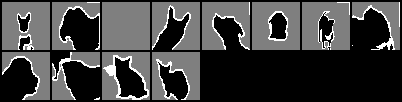

In [12]:
# Let's inspect the segmentation masks corresponding to the images above.
#
# When plotting the segmentation mask, we want to convert the tensor
# into a float tensor with values in the range [0.0 to 1.0]. However, the
# mask tensor has the values (0, 1, 2), so we divide by 2.0 to normalize.
pets_targets_grid = torchvision.utils.make_grid(train_pets_targets / 2.0, nrow=8)
t2img(pets_targets_grid)

### Training functions

In [13]:
# Define training loop. This will train the model for multiple epochs.
#
# epochs: A tuple containing the start epoch (inclusive) and end epoch (exclusive).
#         The model is trained for [epoch[0] .. epoch[1]) epochs.
#
def train_loop(model, loader, test_data, epochs, optimizer, scheduler, save_path,print_every=2,show_plots=False):
    if save_path is not None:
        os.makedirs(save_path, exist_ok=True)
    test_inputs, test_targets = test_data
    epoch_i, epoch_j = epochs
    for i in range(epoch_i, epoch_j):
        epoch = i
        print(f"Epoch: {i:02d}, Learning Rate: {optimizer.param_groups[0]['lr']}")
        train_model(model, loader, optimizer)
        if i%print_every==0 or (epoch == epoch_j-1):
            
            with torch.inference_mode():
                # Display the plt in the final training epoch.
                print_test_dataset_masks(model, test_inputs, test_targets, 
                                         epoch=epoch, save_path=save_path, show_plot=(epoch == epoch_j-1) or show_plots)

        if scheduler is not None:
            scheduler.step()

### Initialize Unet model

In [14]:
dimension_specification =   {0: {'width_encoder': 15, 'depth_encoder': 1, 'kernel_size_encoder': 3, 
                                 'width_decoder': 20, 'depth_decoder': 1, 'kernel_size_decoder': 3, 'width_skip': 15},
                            1: {'width_encoder': 30, 'depth_encoder': 1, 'kernel_size_encoder': 3, 
                                'width_decoder': 30, 'depth_decoder': 1, 'kernel_size_decoder': 3, 'width_skip': 30},
                             2: {'width_encoder': 30, 'depth_encoder': 1, 'kernel_size_encoder': 3, 
                                'width_decoder': 30, 'depth_decoder': 1, 'kernel_size_decoder': 3, 'width_skip': 30}
                            }

In [15]:
config = {'in_ch': 3,
         'out_ch': 3,
         'n_decoders': 1,
          'output_groupname_to_n_channels': {'object_mask': 3},
          'output_groupname_to_name_to_idx': {'object_mask': {'background': 1,'border': 2,'object': 0}},
          'dimension_specification': dimension_specification,
          'efficiency_optimized': True,
            }

In [16]:
unet = UNet(**config)

In [17]:
print_model_parameters(unet)

The Model has 0.14M parameters


### Train Unet

In [18]:
n_epochs=30
lr = 1e-3

In [19]:
# Optimizer and Learning Rate Scheduler.
optimizer = torch.optim.Adam(unet.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.7)

Epoch: 00, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.6420
Epoch: 00, Accuracy[Pixel: 0.8035, IoU: 0.5201, Custom IoU: 0.5870]


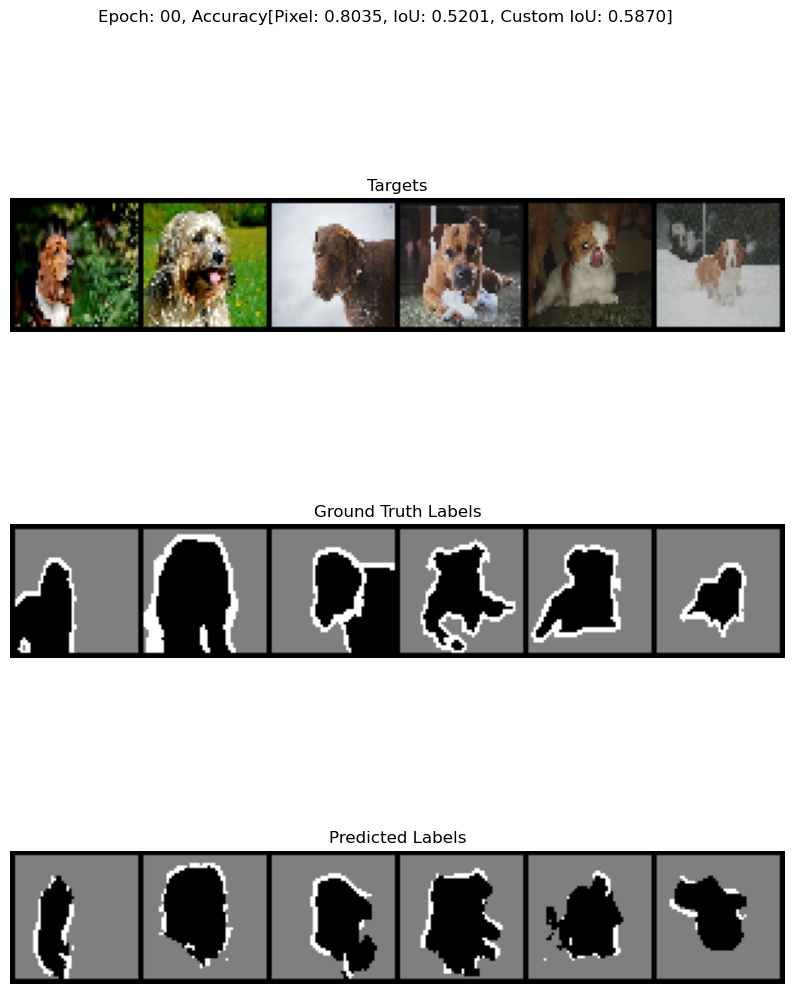

Epoch: 01, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.5157
Epoch: 02, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.4786
Epoch: 03, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.4543
Epoch: 03, Accuracy[Pixel: 0.8260, IoU: 0.5609, Custom IoU: 0.6477]


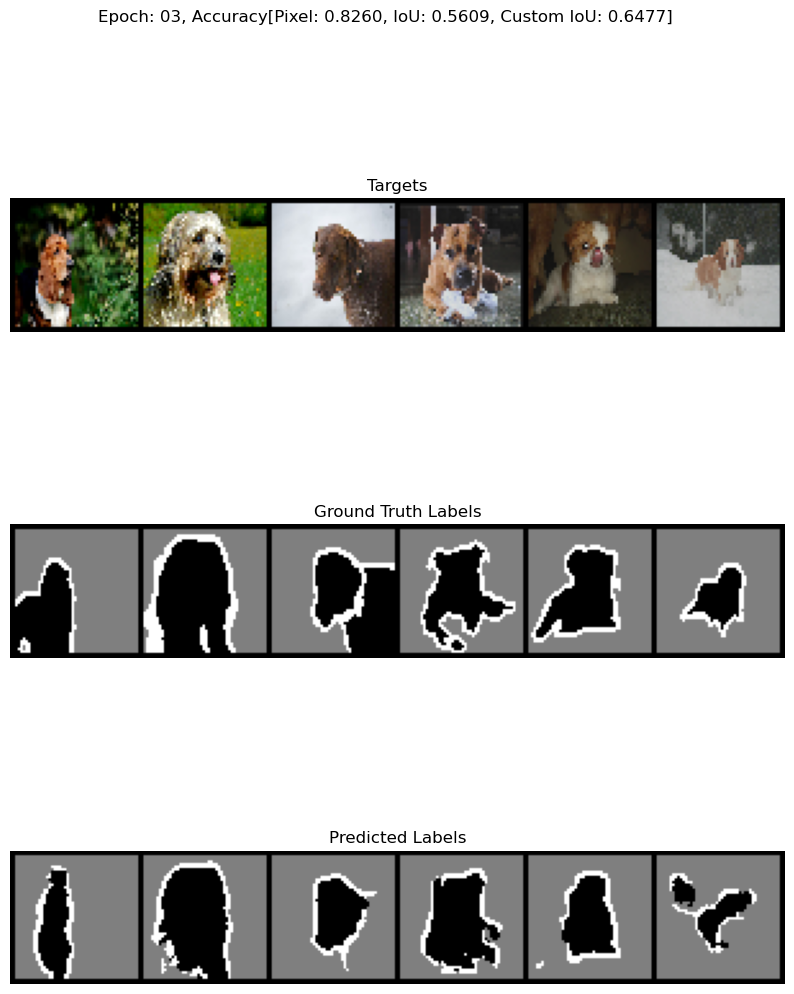

Epoch: 04, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.4343
Epoch: 05, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.4248
Epoch: 06, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.4205
Epoch: 06, Accuracy[Pixel: 0.8441, IoU: 0.6349, Custom IoU: 0.6468]


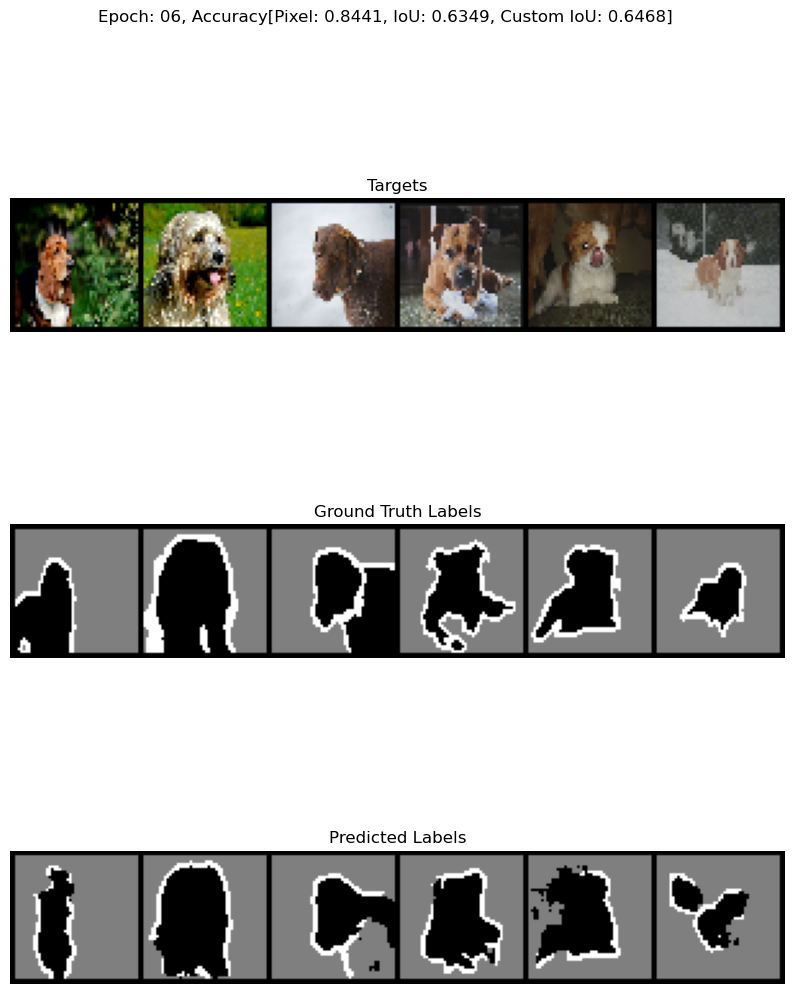

Epoch: 07, Learning Rate: 0.0007
Trained 3680 samples, Loss: 0.3962
Epoch: 08, Learning Rate: 0.0007
Trained 3680 samples, Loss: 0.3867
Epoch: 09, Learning Rate: 0.0007
Trained 3680 samples, Loss: 0.3788
Epoch: 09, Accuracy[Pixel: 0.8511, IoU: 0.5990, Custom IoU: 0.6884]


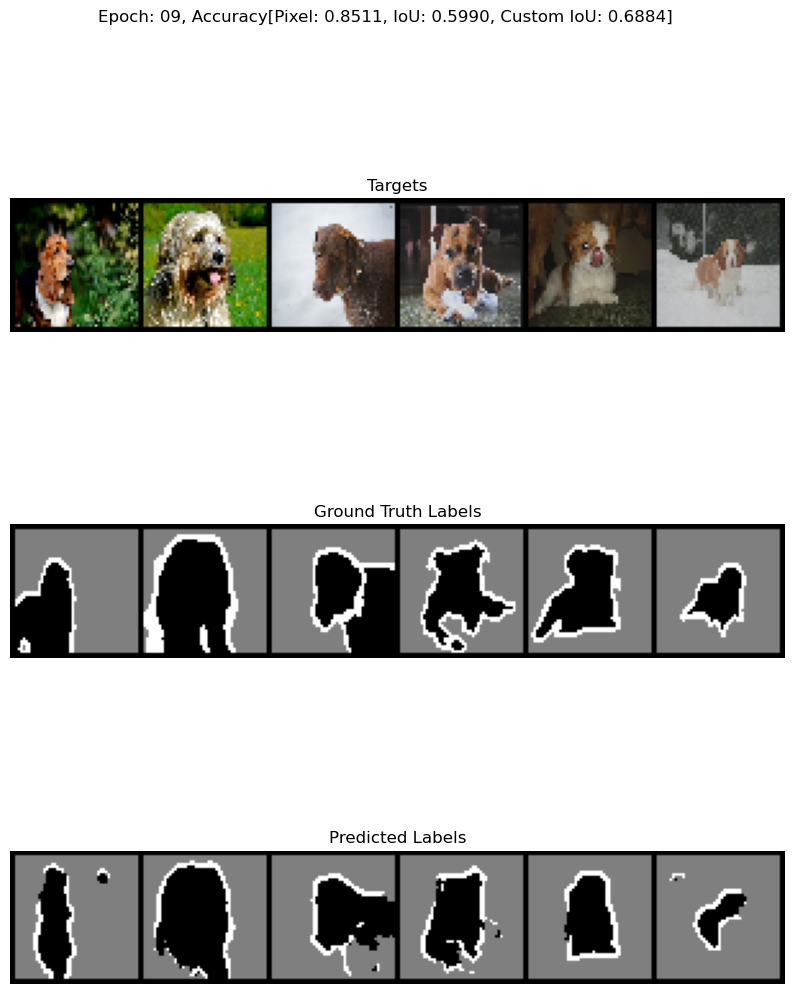

Epoch: 10, Learning Rate: 0.0007
Trained 3680 samples, Loss: 0.3733
Epoch: 11, Learning Rate: 0.0007
Trained 3680 samples, Loss: 0.3679
Epoch: 12, Learning Rate: 0.0007
Trained 3680 samples, Loss: 0.3606
Epoch: 12, Accuracy[Pixel: 0.8476, IoU: 0.6128, Custom IoU: 0.6854]


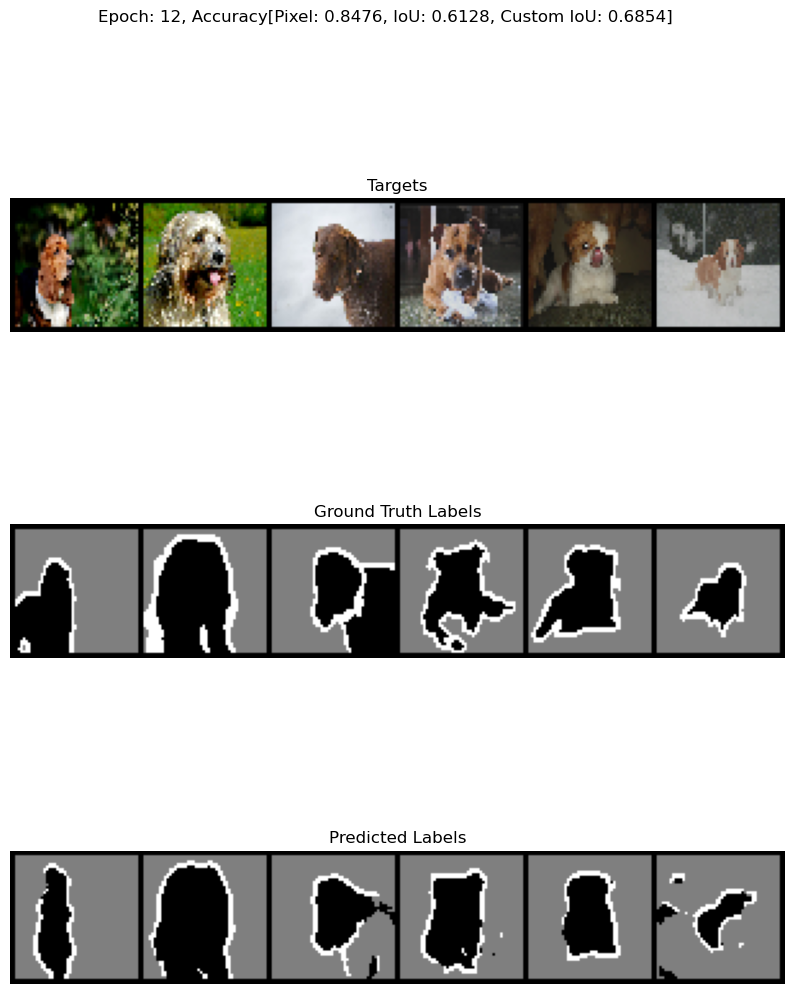

Epoch: 13, Learning Rate: 0.0007
Trained 3680 samples, Loss: 0.3592
Epoch: 14, Learning Rate: 0.00049
Trained 3680 samples, Loss: 0.3411
Epoch: 15, Learning Rate: 0.00049
Trained 3680 samples, Loss: 0.3341
Epoch: 15, Accuracy[Pixel: 0.8897, IoU: 0.6909, Custom IoU: 0.7280]


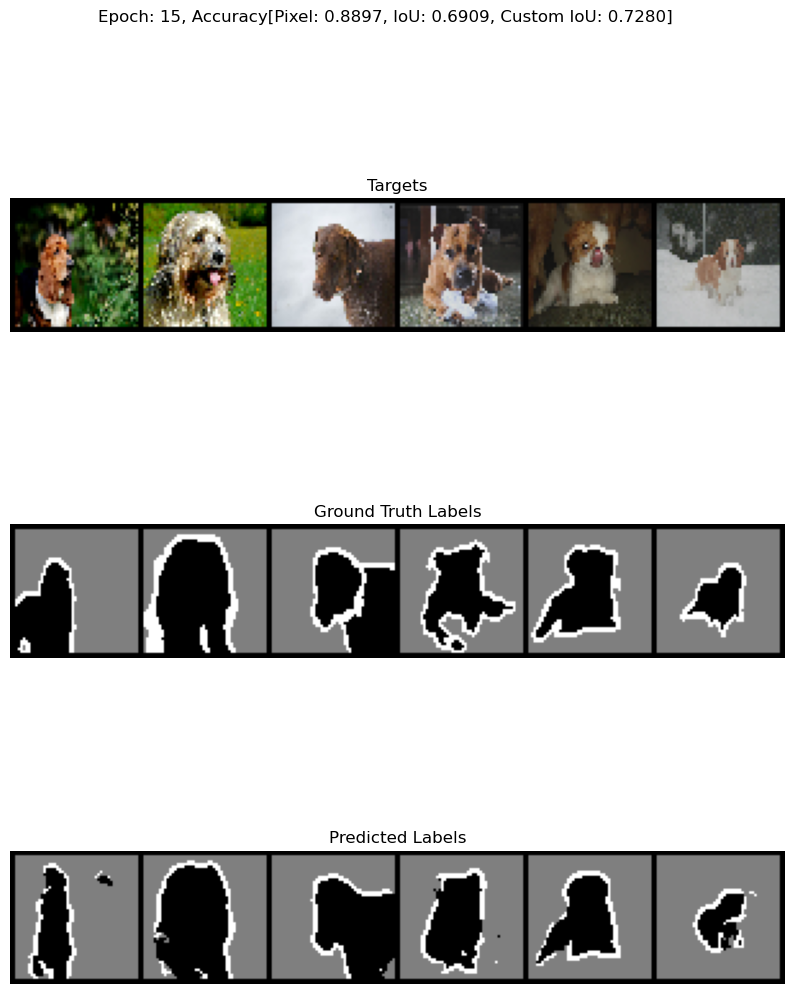

Epoch: 16, Learning Rate: 0.00049
Trained 3680 samples, Loss: 0.3291
Epoch: 17, Learning Rate: 0.00049
Trained 3680 samples, Loss: 0.3257
Epoch: 18, Learning Rate: 0.00049
Trained 3680 samples, Loss: 0.3241
Epoch: 18, Accuracy[Pixel: 0.8991, IoU: 0.7230, Custom IoU: 0.7376]


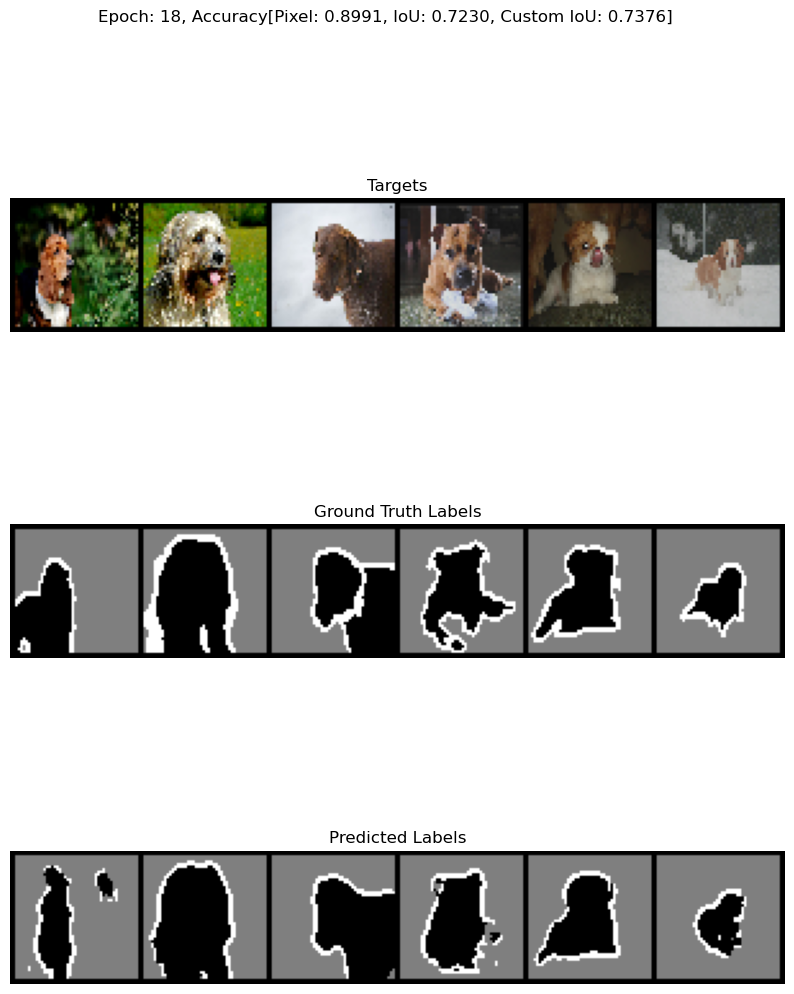

Epoch: 19, Learning Rate: 0.00049
Trained 3680 samples, Loss: 0.3159
Epoch: 20, Learning Rate: 0.00049
Trained 3680 samples, Loss: 0.3169
Epoch: 21, Learning Rate: 0.000343
Trained 3680 samples, Loss: 0.3018
Epoch: 21, Accuracy[Pixel: 0.8983, IoU: 0.7228, Custom IoU: 0.7552]


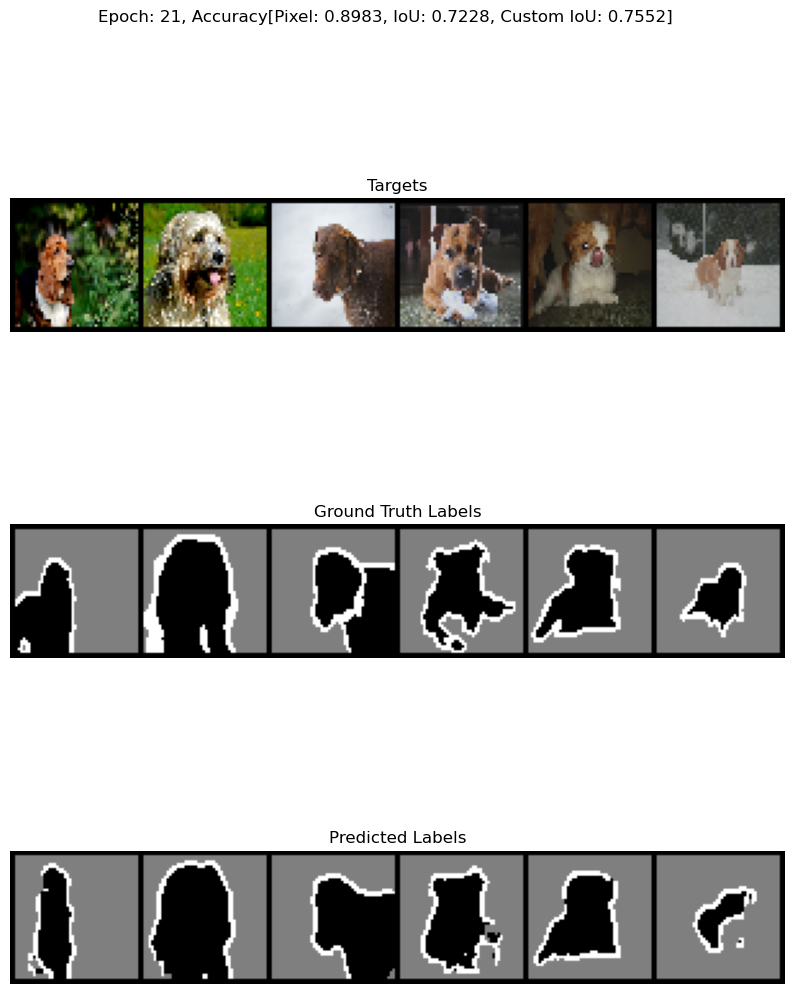

Epoch: 22, Learning Rate: 0.000343
Trained 3680 samples, Loss: 0.2971
Epoch: 23, Learning Rate: 0.000343
Trained 3680 samples, Loss: 0.2943
Epoch: 24, Learning Rate: 0.000343
Trained 3680 samples, Loss: 0.2931
Epoch: 24, Accuracy[Pixel: 0.8912, IoU: 0.6915, Custom IoU: 0.7437]


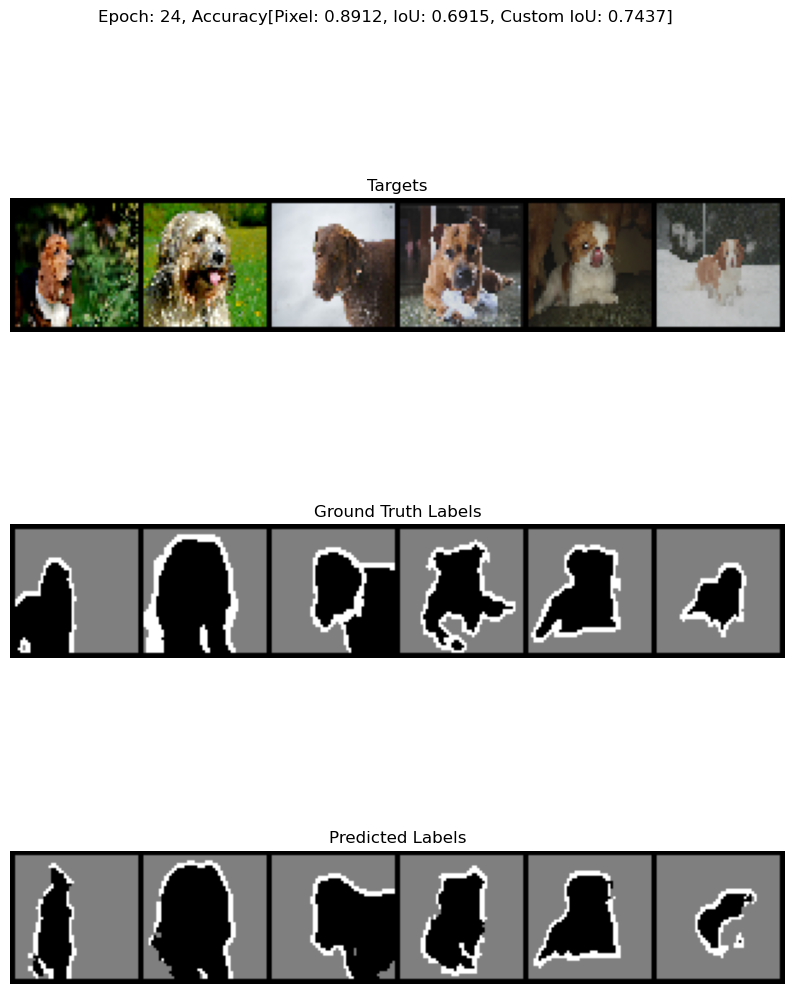

Epoch: 25, Learning Rate: 0.000343
Trained 3680 samples, Loss: 0.2889
Epoch: 26, Learning Rate: 0.000343
Trained 3680 samples, Loss: 0.2884
Epoch: 27, Learning Rate: 0.000343
Trained 3680 samples, Loss: 0.2850
Epoch: 27, Accuracy[Pixel: 0.8980, IoU: 0.7055, Custom IoU: 0.7438]


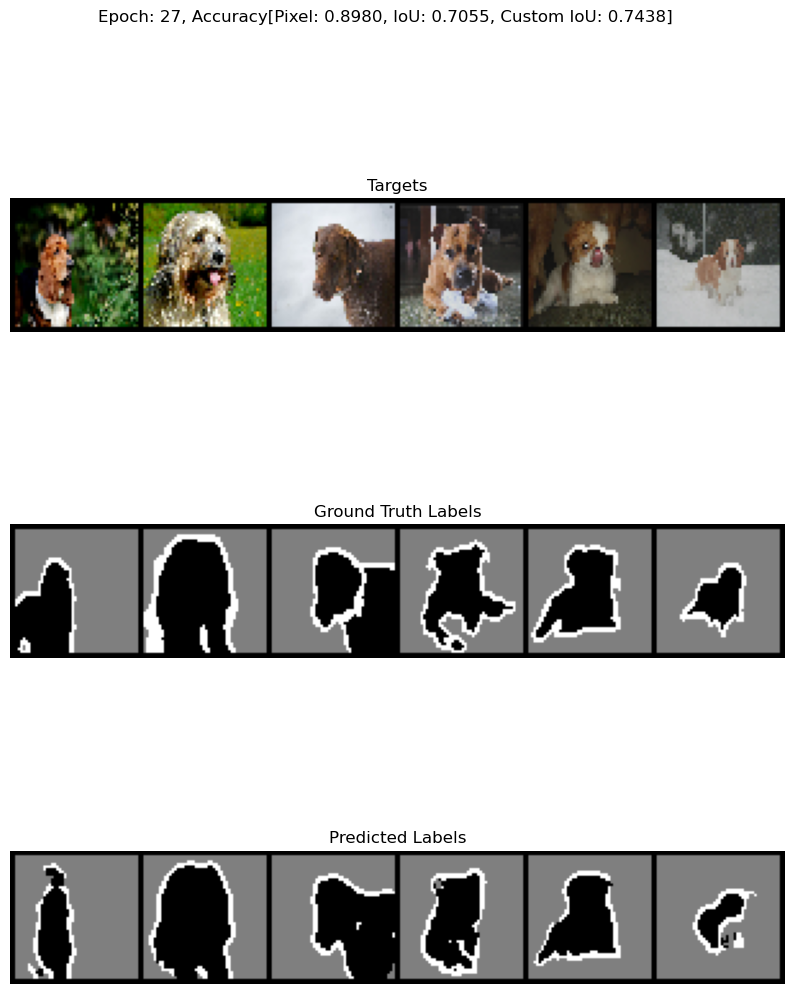

Epoch: 28, Learning Rate: 0.00024009999999999998
Trained 3680 samples, Loss: 0.2769
Epoch: 29, Learning Rate: 0.00024009999999999998
Trained 3680 samples, Loss: 0.2749
Epoch: 29, Accuracy[Pixel: 0.8967, IoU: 0.7048, Custom IoU: 0.7511]


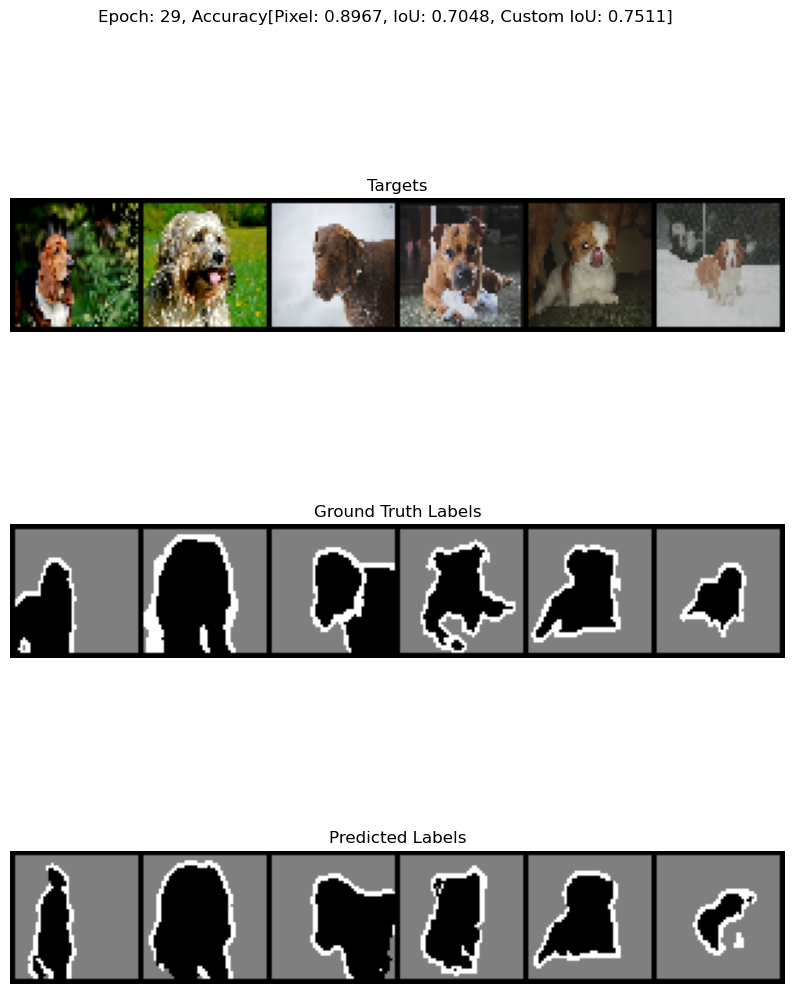

In [20]:
train_loop(unet, pets_train_loader, (test_pets_inputs, test_pets_targets), (0, n_epochs), 
                           optimizer, scheduler, save_path=None,print_every=3,show_plots=True)

The Model has 0.14M parameters
Start evaluation ...
Epoch: 00, Accuracy[Pixel: 0.8333, IoU: 0.6222, Custom IoU: 0.6604]


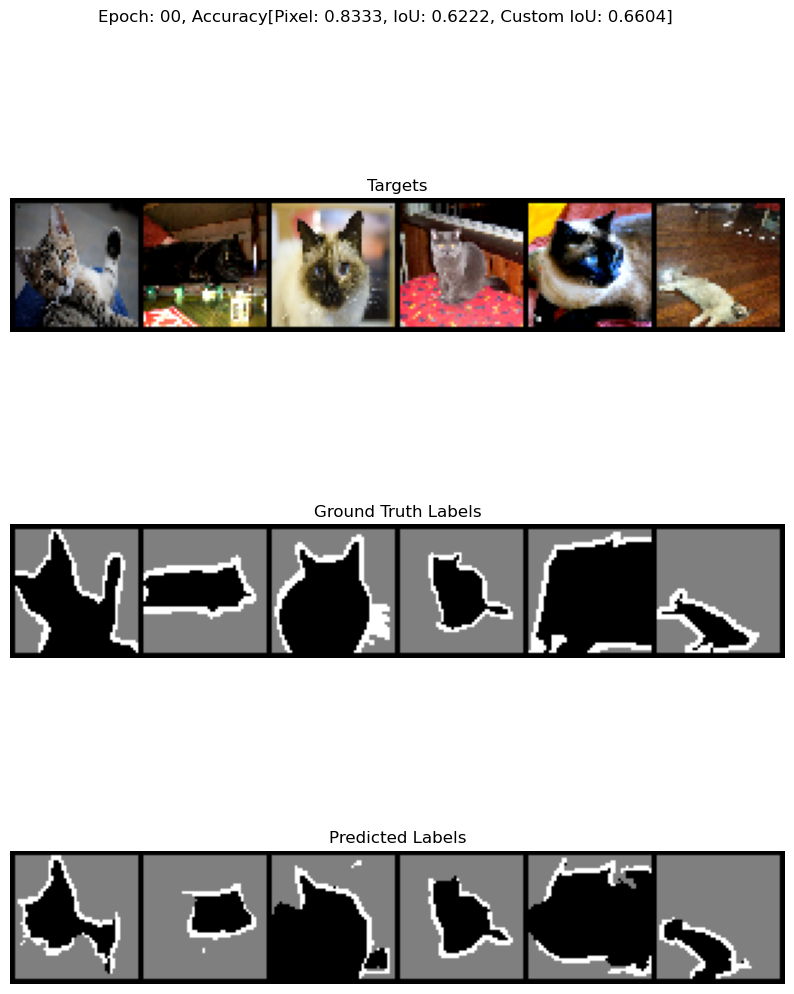

Epoch: 00, Accuracy[Pixel: 0.8291, IoU: 0.7291, Custom IoU: 0.6662]


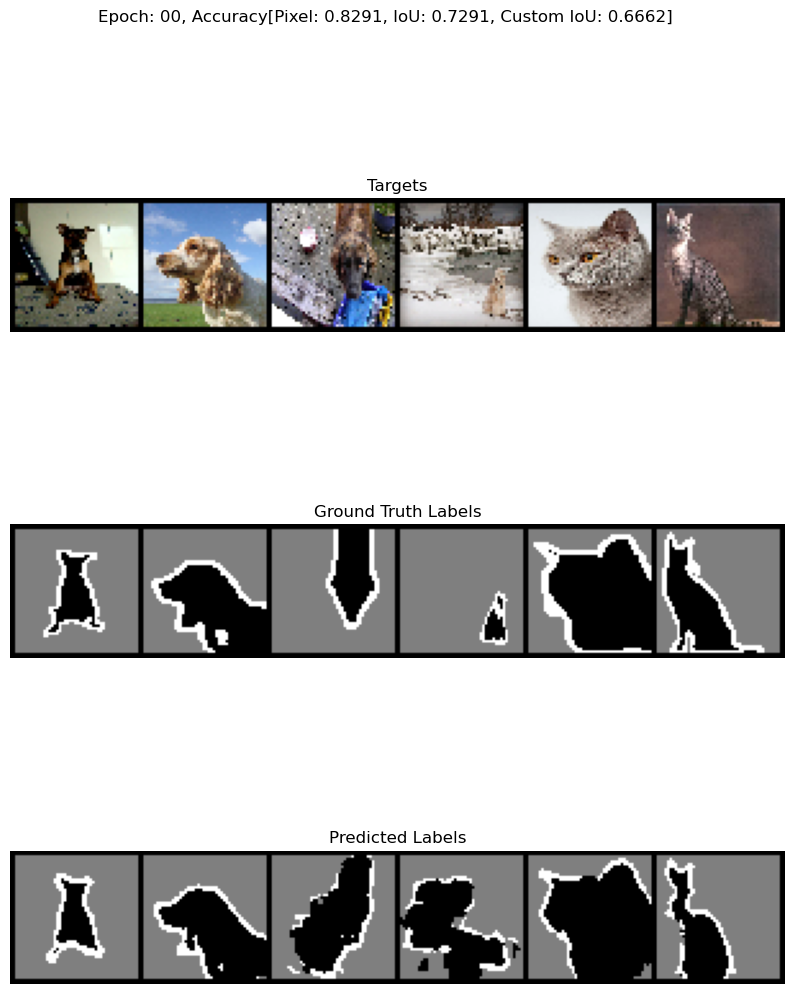

Epoch: 00, Accuracy[Pixel: 0.8723, IoU: 0.6981, Custom IoU: 0.7120]


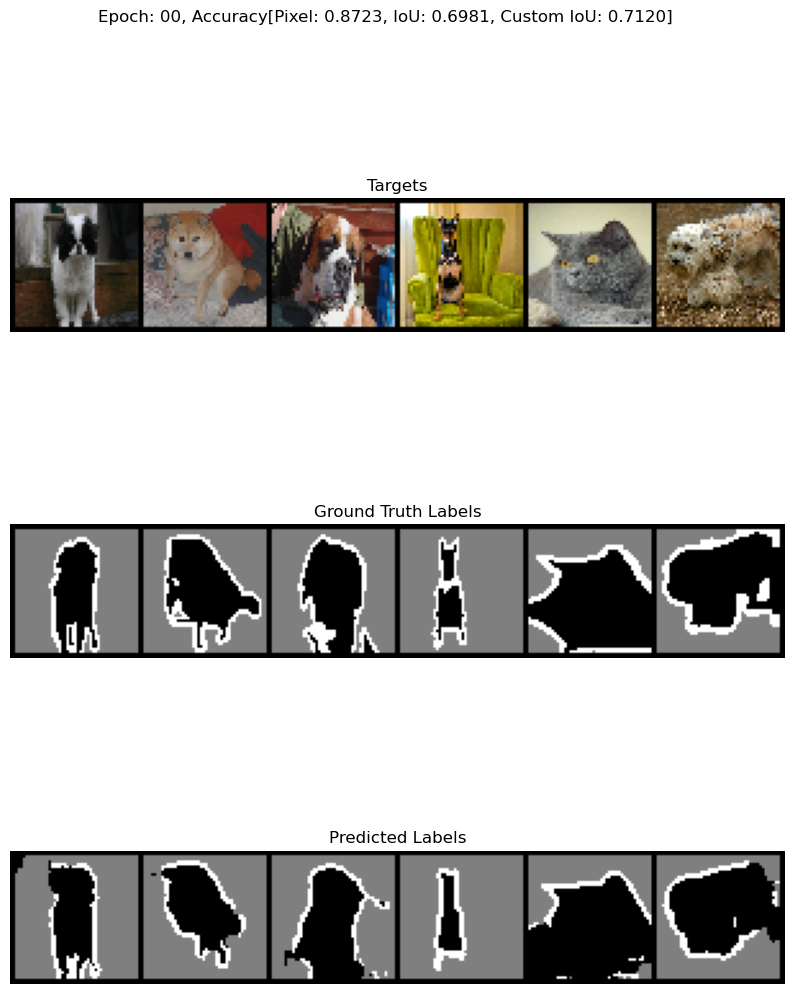

Epoch: 00, Accuracy[Pixel: 0.8074, IoU: 0.6435, Custom IoU: 0.6387]


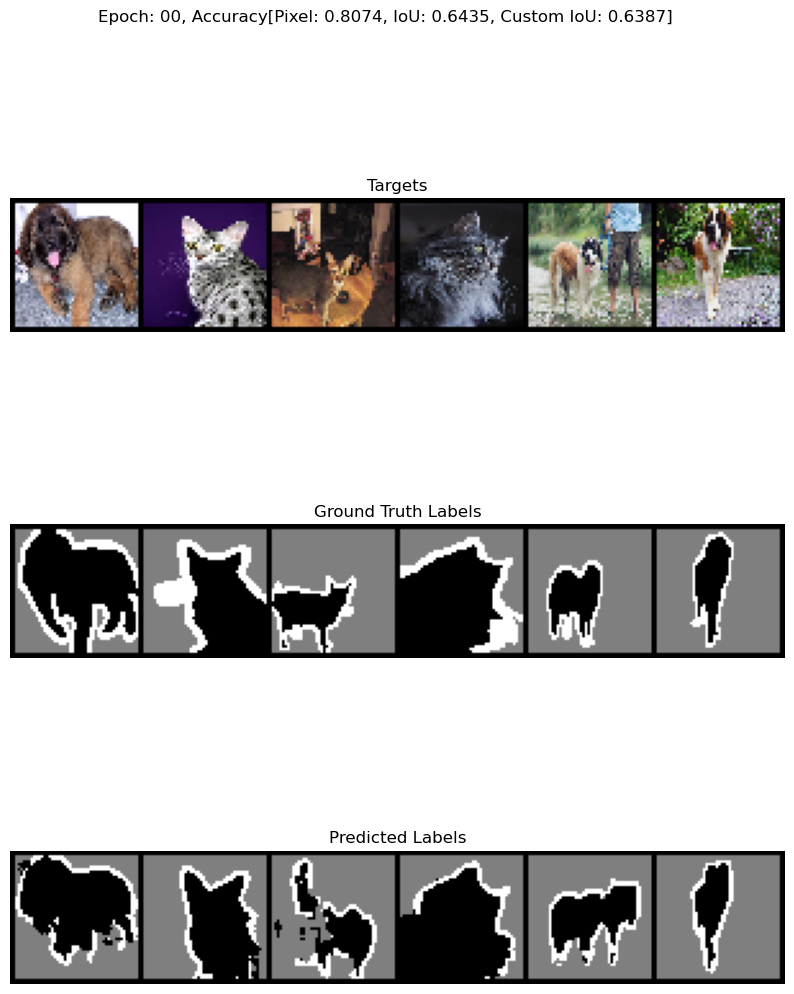

Epoch: 00, Accuracy[Pixel: 0.8405, IoU: 0.6634, Custom IoU: 0.6619]


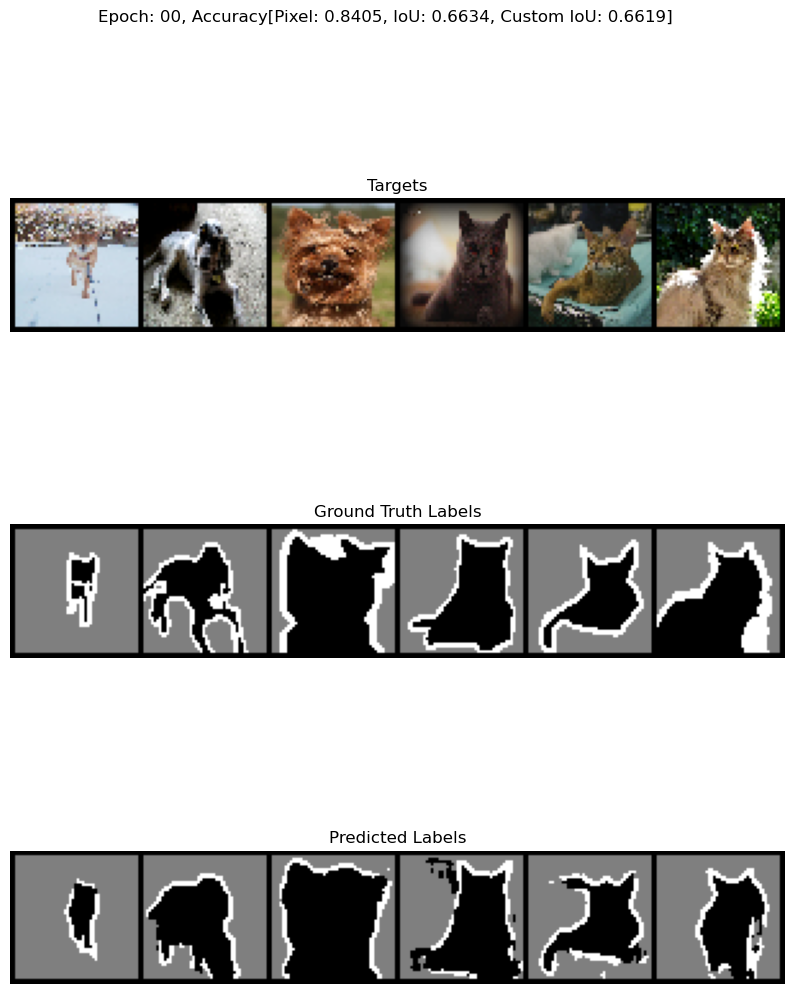

Epoch: 00, Accuracy[Pixel: 0.8917, IoU: 0.7386, Custom IoU: 0.7317]


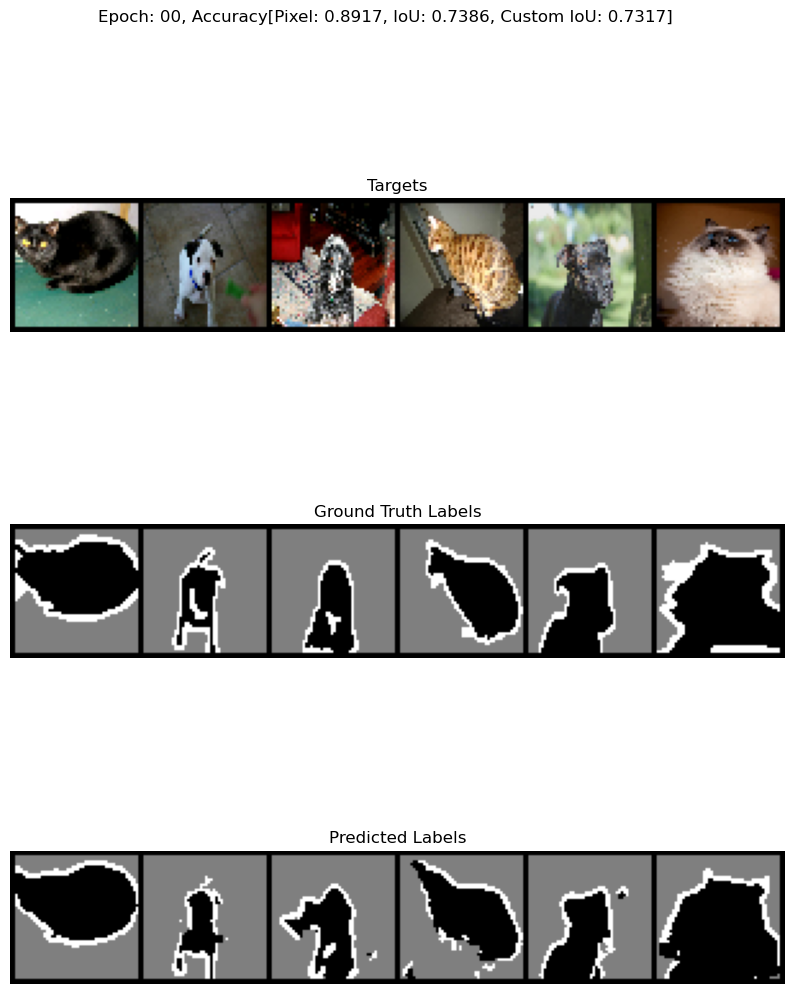

Epoch: 00, Accuracy[Pixel: 0.9254, IoU: 0.8081, Custom IoU: 0.7925]


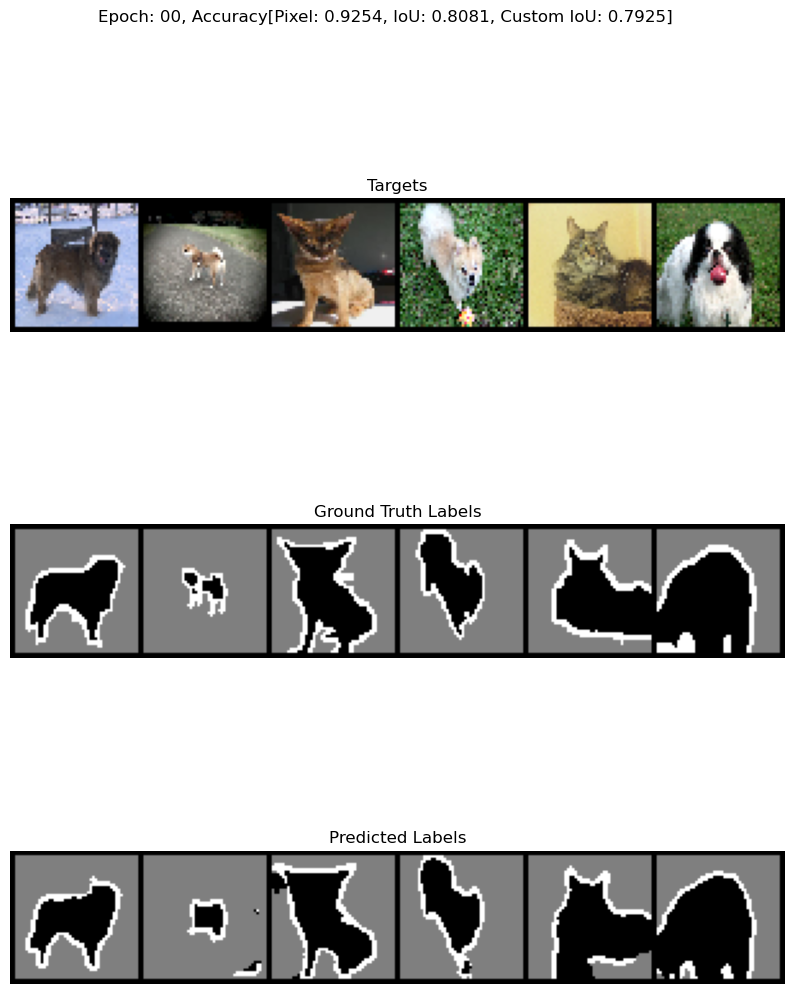

Epoch: 00, Accuracy[Pixel: 0.8597, IoU: 0.6080, Custom IoU: 0.7151]


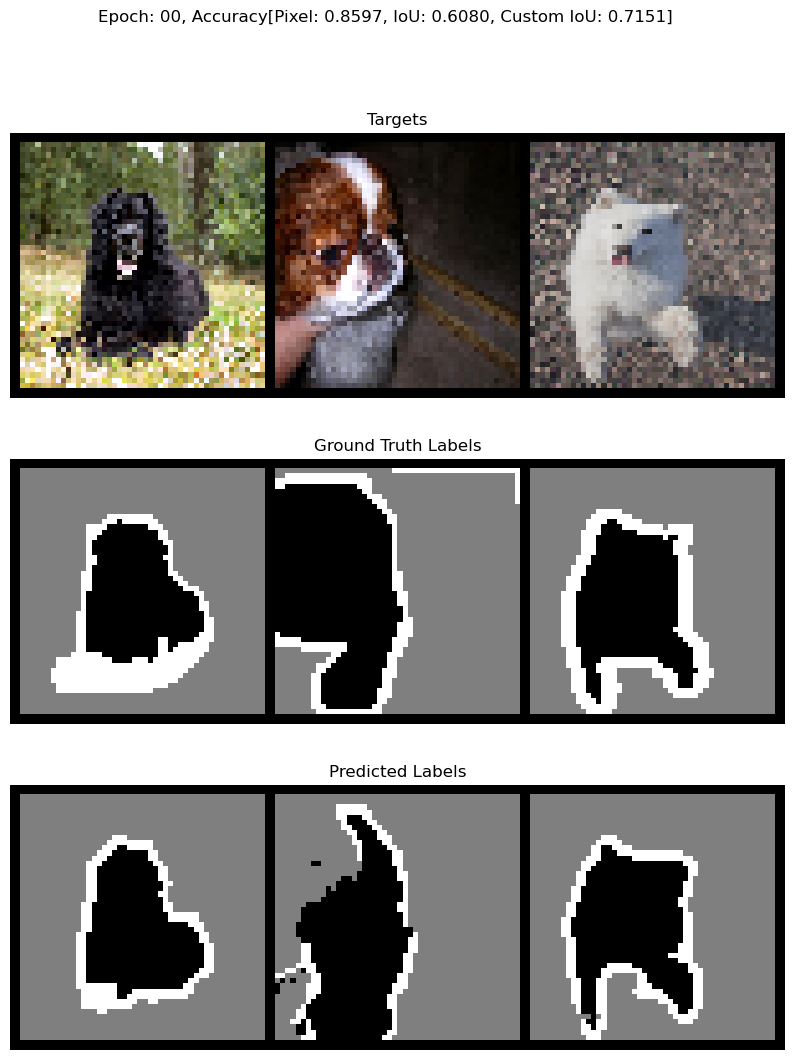

Test Dataset Accuracy
Pixel Accuracy: 0.8598, IoU Accuracy: 0.6777, Custom IoU Accuracy: 0.6985


In [21]:
test_dataset_accuracy(unet, pets_test_loader,show_every_k_batches=100)